In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.linear_model import RidgeCV, LassoCV, Lasso, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn import metrics

%matplotlib inline

# ---------------- 500ms, Perf on Attacked Binary ------------------ 

In [19]:
adata = pd.read_csv('Data/Attacked/500ms.txt', delim_whitespace=True)
adata = adata.drop(adata.columns[3], axis=1)
adata = adata.drop(adata.columns[3], axis=1)
adata = adata.drop(adata.columns[3], axis=1)
adata = adata.drop(adata.columns[3], axis=1)
adata = adata.drop(adata.columns[3], axis=1)
adata.columns = ['Time', 'Value', 'Type']
adata.head()

,Time,Value,Type
0,0.505896,5698587,cache-references
1,0.505896,1373690,cache-misses
2,0.505896,314784633,cycles
3,0.505896,309279292,instructions
4,0.505896,20824700,branches


In [20]:
instructions = adata[adata.Type.isin(['instructions'])]
cache_misses = adata[adata.Type.isin(['cache-misses'])]
cache_ref = adata[adata.Type.isin(['cache-references'])]
page_faults = adata[adata.Type.isin(['faults'])]
cycles = adata[adata.Type.isin(['cycles'])]
migrations = adata[adata.Type.isin(['migrations'])]
branches = adata[adata.Type.isin(['branches'])]
context = adata[adata.Type.isin(['context-switches'])]

cycles.head()

,Time,Value,Type
2,0.505896,314784633,cycles
10,1.007363,833474840,cycles
18,1.508233,1314696599,cycles
26,2.009226,1367382516,cycles
34,2.509779,1370115742,cycles


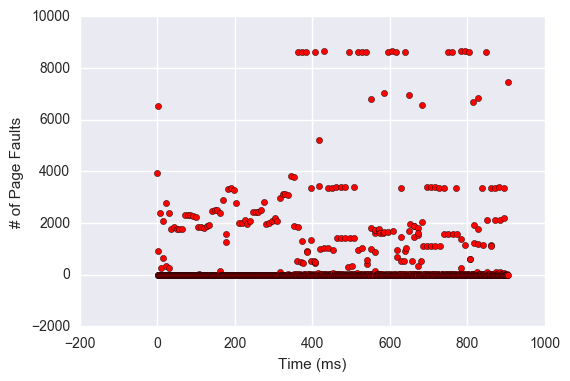

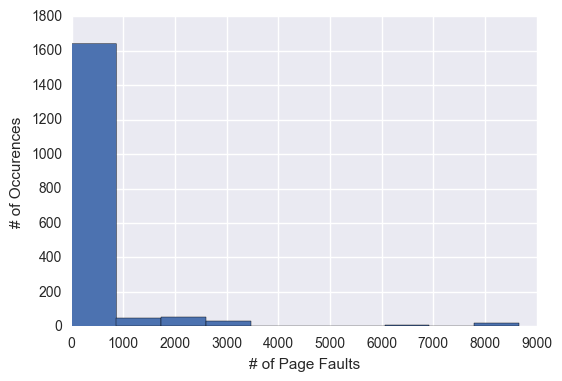

In [21]:
plt.scatter(page_faults.Time, page_faults.Value, c='r')
plt.xlabel('Time (ms)')
plt.ylabel('# of Page Faults')
plt.show()

plt.hist(page_faults.Value)
plt.xlabel('# of Page Faults')
plt.ylabel('# of Occurences')
plt.show()

In [22]:
miss_rate = (cache_misses.Value.mean()/cache_ref.Value.mean())
print "Cache miss rate: " 
print miss_rate

Cache miss rate: 
0.732756636677


# -------------------------Benchmark Data, ZeusMP, 75ms----------------------------

In [23]:
data = pd.read_csv('Data/Benchmark/500ms_ZeusMP.txt', delim_whitespace=True)
data = data.drop(data.columns[3], axis=1)
data = data.drop(data.columns[3], axis=1)
data = data.drop(data.columns[3], axis=1)
data = data.drop(data.columns[3], axis=1)
data = data.drop(data.columns[3], axis=1)
data.columns = ['Time', 'Value', 'Type']

IOError: File Data/Benchmark/500ms_ZeusMP.txt does not exist

In [ ]:
ben_instructions = data[data.Type.isin(['instructions'])]
ben_cache_misses = data[data.Type.isin(['cache-misses'])]
ben_cache_ref = data[data.Type.isin(['cache-references'])]
ben_page_faults = data[data.Type.isin(['faults'])]
ben_cycles = data[data.Type.isin(['cycles'])]
ben_migrations = data[data.Type.isin(['migrations'])]
ben_branches = data[data.Type.isin(['branches'])]
ben_context = data[data.Type.isin(['context-switches'])]

In [ ]:
plt.scatter(ben_page_faults.Time, ben_page_faults.Value)
plt.xlabel('Time (ms)')
plt.ylabel('# of Page Faults')
plt.show()

plt.scatter(ben_page_faults.Time, ben_page_faults.Value)
plt.scatter(page_faults.Time, page_faults.Value, c='r')
plt.xlabel('Time (ms)')
plt.ylabel('# of Page Faults')
plt.show()

plt.hist(ben_page_faults.Value)
plt.xlabel('# of Page Faults')
plt.ylabel('# of Occurences')
plt.show()

In [ ]:
miss_rate = (ben_cache_misses.Value.mean()/ben_cache_ref.Value.mean())
miss_std = ben_cache_misses.Value.std()
print "Cache miss rate: " 
print miss_rate

In [ ]:
plt.scatter(ben_cache_misses.Time, ben_cache_misses.Value)
plt.xlabel('Time (ms)')
plt.ylabel('# of Cache Misses')
plt.show()

print "Mean: "
print ben_cache_misses.Value.mean()
print "STD: "
print ben_cache_misses.Value.std()

plt.scatter(cache_misses.Time, cache_misses.Value, c='r')
plt.xlabel('Time (ms)')
plt.ylabel('# of Cache Misses')
plt.show()

print "Mean: "
print cache_misses.Value.mean()
print "STD: "
print cache_misses.Value.std()

# ----------- Creating a Model ----------------

In [ ]:
# First, we need to preprocess the data
instructions.index = range(len(instructions))
cache_misses.index = range(len(cache_misses))
cache_ref.index = range(len(cache_ref))
page_faults.index = range(len(page_faults))
cycles.index = range(len(cycles))
migrations.index = range(len(migrations))
branches.index = range(len(branches))
context.index = range(len(context))

ben_instructions.index = range(len(ben_instructions))
ben_cache_misses.index = range(len(ben_cache_misses))
ben_cache_ref.index = range(len(ben_cache_ref))
ben_page_faults.index = range(len(ben_page_faults))
ben_cycles.index = range(len(ben_cycles))
ben_migrations.index = range(len(ben_migrations))
ben_branches.index = range(len(ben_branches))
ben_context.index = range(len(ben_context))

ones = pd.DataFrame(np.ones(len(instructions)))
zeros = pd.DataFrame(np.zeros(len(ben_instructions)))

attack_data = pd.concat([instructions.Value, cache_misses.Value, cache_ref.Value, page_faults.Value, 
                        cycles.Value, migrations.Value, branches.Value, context.Value, ones], axis=1)

bench_data = pd.concat([ben_instructions.Value, ben_cache_misses.Value, ben_cache_ref.Value, ben_page_faults.Value, 
                        ben_cycles.Value, ben_migrations.Value, ben_branches.Value, ben_context.Value, zeros], axis=1)

total_data = pd.concat([attack_data, bench_data], axis=0)
total_data.columns = ['Instructions', 'Cache_misses', 'Cache_references', 'Page_Faults', 'Cycles', 'Migrations', 
                      'Branches', 'Context', 'Type']
total_data = total_data.drop('Migrations', axis=1)

# First, we'll shuffle the rows
total_data = total_data.sample(frac=1).reset_index(drop=True)
total_data

In [ ]:
msk = np.random.rand(len(total_data)) < 0.8
train = total_data[msk]
test = total_data[~msk]

X = total_data.ix[:, :7]
y = total_data.ix[:, 7]

X_train = train.ix[:,:7]
y_train = train.ix[:,7]

X_test = test.ix[:,:7]
y_test = test.ix[:,7]

In [ ]:
model_ridge = RidgeCV(alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]).fit(X_train, y_train)
pred = model_ridge.predict(X_test)

pred_norm = (pred - pred.mean()) / (pred.max() - pred.min())
pred_norm = pred_norm - pred_norm.min()

In [ ]:
plt.scatter(range(0,len(X_test)), y_test)
plt.scatter(range(0,len(X_test)), pred_norm, c='r')
plt.show()

In [ ]:
ridge_score = -cross_val_score(model_ridge, X_train, y_train, scoring="mean_squared_error")
print("Ridge Best RMSE: {}".format(np.sqrt(ridge_score).mean()))

In [ ]:
model_lasso = LassoCV(alphas= [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]).fit(X_train, y_train)
pred = model_lasso.predict(X_test)

pred_norm = (pred - pred.mean()) / (pred.max() - pred.min())
pred_norm = pred_norm - pred_norm.min()
pred_norm

In [ ]:
plt.scatter(range(0,20), y_test.ix[:20,:])
plt.scatter(range(0,20), pred_norm.ix[:20,:], c='r')
plt.show()

In [ ]:
lasso_score = -cross_val_score(model_lasso, X, y, scoring="mean_squared_error")
print("Lasso Best RMSE: {}".format(np.sqrt(lasso_score).mean()))

# K-Fold Cross Validations

In [ ]:
# Let's use K-Fold Cross Validation

X = total_data.ix[:, :7]
y = total_data.ix[:, 7]

In [ ]:
kf = KFold(n_splits=4)
total_score = 0

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model_lasso = LassoCV(alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]).fit(X_train, y_train)
    
    pred = model_lasso.predict(X_test)
    pred_norm = (pred - pred.mean()) / (pred.max() - pred.min())
    pred_norm = pred_norm - pred_norm.min()

    plt.scatter(range(0,len(X_test)), y_test)
    plt.scatter(range(0,len(X_test)), pred_norm, c='r')
    plt.show()
    
    lasso_score = -cross_val_score(model_lasso, X_test, y_test, scoring="mean_squared_error")
    print("Lasso Best RMSE: {}".format(np.sqrt(lasso_score).mean()))
    total_score += np.sqrt(lasso_score.mean())
    
total_score /= 4
print "Average score: " 
print total_score

In [ ]:
# Let's feature engineer the Page Faults, which should be the main feature

total_data1 = total_data
total_data1['Page_Faults'] = total_data['Page_Faults']**2

X = total_data1.ix[:, :7]
y = total_data1.ix[:, 7]

total_data

In [ ]:
total_score = 0

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model_lasso = LassoCV(alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]).fit(X_train, y_train)
    
    pred = model_lasso.predict(X_test)
    pred_norm = (pred - pred.mean()) / (pred.max() - pred.min())
    pred_norm = pred_norm - pred_norm.min()

    plt.scatter(range(0,len(X_test)), y_test)
    plt.scatter(range(0,len(X_test)), pred_norm, c='r')
    plt.show()
    
    lasso_score = -cross_val_score(model_lasso, X_test, y_test, scoring="mean_squared_error")
    print("Lasso Best RMSE: {}".format(np.sqrt(lasso_score).mean()))
    total_score += np.sqrt(lasso_score.mean())
    
total_score /= 4
print ""
print "Average score: " 
print total_score

In [ ]:
# Let's also add a category if there are no page faults

bool_col = total_data['Page_Faults'] > 0
total_data1['page_bool'] = np.where(bool_col, 1, 0)

cols = total_data1.columns.tolist()
cols = cols[-1:] + cols[:-1]
total_data2 = total_data1[cols]

X = total_data2.ix[:, :8]
y = total_data2.ix[:, 8]

total_data2

In [ ]:
total_score = 0

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model_lasso = LassoCV(alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]).fit(X_train, y_train)
    
    pred = model_lasso.predict(X_test)
    pred_norm = (pred - pred.mean()) / (pred.max() - pred.min())
    pred_norm = pred_norm - pred_norm.min()

    plt.scatter(range(0,len(X_test)), y_test)
    plt.scatter(range(0,len(X_test)), pred_norm, c='r')
    plt.show()
    
    lasso_score = -cross_val_score(model_lasso, X_test, y_test, scoring="mean_squared_error")
    print("Lasso Best RMSE: {}".format(np.sqrt(lasso_score).mean()))
    total_score += np.sqrt(lasso_score.mean())
    
total_score /= 4
print ""
print "Average score: " 
print total_score

In [ ]:
X = total_data1.ix[:, :7]
y = total_data1.ix[:, 7]

In [ ]:
total_score = 0

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model_net = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]).fit(X_train, y_train)
    
    pred = model_net.predict(X_test)
    pred_norm = (pred - pred.mean()) / (pred.max() - pred.min())
    pred_norm = pred_norm - pred_norm.min()

    plt.scatter(range(0,len(X_test)), y_test)
    plt.scatter(range(0,len(X_test)), pred_norm, c='r')
    plt.show()
    
    net_score = -cross_val_score(model_net, X_test, y_test, scoring="mean_squared_error")
    print("Elastic Net Best RMSE: {}".format(np.sqrt(net_score).mean()))
    total_score += np.sqrt(net_score.mean())
    
total_score /= 4
print ""
print "Average score: " 
print total_score

In [ ]:
X = total_data1.ix[:, :7]
y = total_data1.ix[:, 7]

In [ ]:
total_score = 0

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = RidgeCV(alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]).fit(X_train, y_train)
    
    pred = model.predict(X_test)
    pred_norm = (pred - pred.mean()) / (pred.max() - pred.min())
    pred_norm = pred_norm - pred_norm.min()

    plt.scatter(range(0,len(X_test)), y_test)
    plt.scatter(range(0,len(X_test)), pred_norm, c='r')
    plt.show()
    
    score = -cross_val_score(model, X_test, y_test, scoring="mean_squared_error")
    print("Ridge Best RMSE: {}".format(np.sqrt(score).mean()))
    total_score += np.sqrt(score.mean())
    
total_score /= 4
print ""
print "Average score: " 
print total_score

# ------------ Final VM DATA ---------------

In [202]:
adata1 = pd.read_csv('Data/Attacked/flush_reload_1_out.txt', delim_whitespace=True)
adata1 = adata1.drop(adata1.columns[3], axis=1)
adata1 = adata1.drop(adata1.columns[3], axis=1)
adata1 = adata1.drop(adata1.columns[3], axis=1)
adata1 = adata1.drop(adata1.columns[3], axis=1)
adata1 = adata1.drop(adata1.columns[3], axis=1)
adata1.columns = ['Time', 'Value', 'Type']

adata2 = pd.read_csv('Data/Attacked/flush_reload_2_out.txt', delim_whitespace=True)
adata2 = adata2.drop(adata2.columns[3], axis=1)
adata2 = adata2.drop(adata2.columns[3], axis=1)
adata2 = adata2.drop(adata2.columns[3], axis=1)
adata2 = adata2.drop(adata2.columns[3], axis=1)
adata2 = adata2.drop(adata2.columns[3], axis=1)
adata2.columns = ['Time', 'Value', 'Type']

adata3 = pd.read_csv('Data/Attacked/flush_reload_3_out.txt', delim_whitespace=True)
adata3 = adata3.drop(adata3.columns[3], axis=1)
adata3 = adata3.drop(adata3.columns[3], axis=1)
adata3 = adata3.drop(adata3.columns[3], axis=1)
adata3 = adata3.drop(adata3.columns[3], axis=1)
adata3 = adata3.drop(adata3.columns[3], axis=1)
adata3.columns = ['Time', 'Value', 'Type']

adata3.head()

,Time,Value,Type
0,0.500938,3150986,L1-dcache-store-misses
1,0.500938,0,L1-dcache-prefetch-misses
2,0.500938,3121441,L1-icache-load-misses
3,1.001436,802859,L1-dcache-store-misses
4,1.001436,0,L1-dcache-prefetch-misses


In [203]:
atotal = np.vstack([adata1, adata2, adata3])

ar412e = adata1[adata1.Type.isin(['r412e'])].reset_index(drop=True)
ar4f2e = adata1[adata1.Type.isin(['r4f2e'])].reset_index(drop=True)
abranchloads = adata1[adata1.Type.isin(['branch-loads'])].reset_index(drop=True)
abranchmisses = adata1[adata1.Type.isin(['branch-load-misses'])].reset_index(drop=True)
afaults = adata1[adata1.Type.isin(['faults'])].reset_index(drop=True)
adtlbload = adata2[adata2.Type.isin(['dTLB-load-misses'])].reset_index(drop=True)
adtlbstore = adata2[adata2.Type.isin(['dTLB-store-misses'])].reset_index(drop=True)
al1load = adata2[adata2.Type.isin(['L1-dcache-load-misses'])].reset_index(drop=True)
al1store = adata3[adata3.Type.isin(['L1-dcache-store-misses'])].reset_index(drop=True)
al1prefetch = adata3[adata3.Type.isin(['L1-dcache-prefetch-misses'])].reset_index(drop=True)
al1icacheload = adata3[adata3.Type.isin(['L1-icache-load-misses'])].reset_index(drop=True)

In [204]:
data1 = pd.read_csv('Data/Benchmark/gobmk_1.txt', delim_whitespace=True)
data1 = data1.drop(data1.columns[3], axis=1)
data1 = data1.drop(data1.columns[3], axis=1)
data1 = data1.drop(data1.columns[3], axis=1)
data1 = data1.drop(data1.columns[3], axis=1)
data1 = data1.drop(data1.columns[3], axis=1)
data1.columns = ['Time', 'Value', 'Type']

data2 = pd.read_csv('Data/Benchmark/gobmk_2.txt', delim_whitespace=True)
data2 = data2.drop(data2.columns[3], axis=1)
data2 = data2.drop(data2.columns[3], axis=1)
data2 = data2.drop(data2.columns[3], axis=1)
data2 = data2.drop(data2.columns[3], axis=1)
data2 = data2.drop(data2.columns[3], axis=1)
data2.columns = ['Time', 'Value', 'Type']

data3 = pd.read_csv('Data/Benchmark/gobmk_3.txt', delim_whitespace=True)
data3 = data3.drop(data3.columns[3], axis=1)
data3 = data3.drop(data3.columns[3], axis=1)
data3 = data3.drop(data3.columns[3], axis=1)
data3 = data3.drop(data3.columns[3], axis=1)
data3 = data3.drop(data3.columns[3], axis=1)
data3.columns = ['Time', 'Value', 'Type']

In [205]:
total = np.vstack([data1, data2, data3])

r412e = data1[data1.Type.isin(['r412e'])].reset_index(drop=True)
r4f2e = data1[data1.Type.isin(['r4f2e'])].reset_index(drop=True)
branchloads = data1[data1.Type.isin(['branch-loads'])].reset_index(drop=True)
branchmisses = data1[data1.Type.isin(['branch-load-misses'])].reset_index(drop=True)
faults = data1[data1.Type.isin(['faults'])].reset_index(drop=True)
dtlbload = data3[data3.Type.isin(['dTLB-load-misses'])].reset_index(drop=True)
dtlbstore = data3[data3.Type.isin(['dTLB-store-misses'])].reset_index(drop=True)
l1load = data3[data3.Type.isin(['L1-dcache-load-misses'])].reset_index(drop=True)
l1store = data2[data2.Type.isin(['L1-dcache-store-misses'])].reset_index(drop=True)
l1prefetch = data2[data2.Type.isin(['L1-dcache-prefetch-misses'])].reset_index(drop=True)
l1icacheload = data2[data2.Type.isin(['L1-icache-load-misses'])].reset_index(drop=True)

r412e = r412e.ix[range(0, 1757),:]
r4f2e = r4f2e.ix[range(0, 1757),:]
branchloads = branchloads.ix[range(0, 1757),:]
branchmisses = branchmisses.ix[range(0, 1757),:]
faults = faults.ix[range(0, 1757),:]
dtlbload = dtlbload.ix[range(0, 1757),:]
dtlbstore = dtlbstore.ix[range(0, 1757),:]
l1load = l1load.ix[range(0, 1757),:]
l1store = l1store.ix[range(0, 1757),:]
l1prefetch = l1prefetch.ix[range(0, 1757),:]
l1icacheload = l1icacheload.ix[range(0, 1757),:]

print r412e.shape
print r4f2e.shape
print branchloads.shape
print branchmisses.shape
print faults.shape
print dtlbload.shape
print dtlbstore.shape
print l1load.shape
print l1store.shape
print l1prefetch.shape
print l1icacheload.shape

(1757, 3)
(1757, 3)
(1757, 3)
(1757, 3)
(1757, 3)
(1757, 3)
(1757, 3)
(1757, 3)
(1757, 3)
(1757, 3)
(1757, 3)


In [206]:
ar412e = ar412e.ix[range(0, 1803),:]
ar4f2e = ar4f2e.ix[range(0, 1803),:]
abranchloads = abranchloads.ix[range(0, 1803),:]
abranchmisses = abranchmisses.ix[range(0, 1803),:]
afaults = afaults.ix[range(0, 1803),:]
adtlbload = adtlbload.ix[range(0, 1803),:]
adtlbstore = adtlbstore.ix[range(0, 1803),:]
al1load = al1load.ix[range(0, 1803),:]
al1store = al1store.ix[range(0, 1803),:]
al1prefetch = al1prefetch.ix[range(0, 1803),:]
al1icacheload = al1icacheload.ix[range(0, 1803),:]

print ar412e.shape
print ar4f2e.shape
print abranchloads.shape
print abranchmisses.shape
print afaults.shape
print adtlbload.shape
print adtlbstore.shape
print al1load.shape
print al1store.shape
print al1prefetch.shape
print al1icacheload.shape

(1803, 3)
(1803, 3)
(1803, 3)
(1803, 3)
(1803, 3)
(1803, 3)
(1803, 3)
(1803, 3)
(1803, 3)
(1803, 3)
(1803, 3)


In [207]:
# Let's combine the features into full data sets

r412e.index = range(len(r412e))
r4f2e.index = range(len(r4f2e))
branchloads.index = range(len(branchloads))
branchmisses.index = range(len(branchmisses))
faults.index = range(len(faults))
dtlbload.index = range(len(dtlbload))
dtlbstore.index = range(len(dtlbstore))
l1load.index = range(len(l1load))
l1store.index = range(len(l1store))
l1prefetch.index = range(len(l1prefetch))
l1icacheload.index = range(len(l1icacheload))

ar412e.index = range(len(ar412e))
ar4f2e.index = range(len(ar4f2e))
abranchloads.index = range(len(abranchloads))
abranchmisses.index = range(len(abranchmisses))
afaults.index = range(len(afaults))
adtlbload.index = range(len(adtlbload))
adtlbstore.index = range(len(adtlbstore))
al1load.index = range(len(al1load))
al1store.index = range(len(al1store))
al1prefetch.index = range(len(al1prefetch))
al1icacheload.index = range(len(al1icacheload))

ones = pd.DataFrame(np.ones(len(ar412e)))
zeros = pd.DataFrame(np.zeros(len(r412e)))

bench_data = pd.concat([r412e.Value, r4f2e.Value, branchloads.Value, branchmisses.Value, 
                        faults.Value, dtlbload.Value, dtlbstore.Value, l1load.Value, l1store.Value, l1prefetch.Value,
                        l1icacheload.Value, zeros], axis=1)
bench_data.columns = ['r412e', 'r4f2e', 'branchloads', 'branchmisses', 'faults', 'dtlb_load_misses', 
                      'dtlb_store_misses', 'l1_dcache_load_misses', 'l1_dcache_store_misses', 
                      'l1_dcache_prefetch_misses', 'l1_icache_load_misses', 'type']
bench_data = bench_data.drop('l1_dcache_prefetch_misses', axis=1)

attack_data = pd.concat([ar412e.Value, ar4f2e.Value, abranchloads.Value, abranchmisses.Value, 
                        afaults.Value, adtlbload.Value, adtlbstore.Value, al1load.Value, al1store.Value, 
                        al1prefetch.Value, al1icacheload.Value, ones], axis=1)
attack_data.columns = ['r412e', 'r4f2e', 'branchloads', 'branchmisses', 'faults', 'dtlb_load_misses', 
                      'dtlb_store_misses', 'l1_dcache_load_misses', 'l1_dcache_store_misses', 
                      'l1_dcache_prefetch_misses', 'l1_icache_load_misses', 'type']
attack_data = attack_data.drop('l1_dcache_prefetch_misses', axis=1)

total_data = pd.concat([attack_data, bench_data], axis=0)
total_data.columns = ['r412e', 'r4f2e', 'branchloads', 'branchmisses', 'faults', 'dtlb_load_misses', 
                      'dtlb_store_misses', 'l1_dcache_load_misses', 'l1_dcache_store_misses', 
                      'l1_icache_load_misses', 'type']

# First, we'll shuffle the rows
total_data
total_data = total_data.sample(frac=1)

In [208]:
msk = np.random.rand(len(total_data)) < 0.8
train = total_data[msk].reset_index(drop=True)
test = total_data[~msk].reset_index(drop=True)

X_train = train.ix[:,0:10]
y_train = train.ix[:,10]

X_test = test.ix[:,0:10]
y_test = test.ix[:,10]

X_train = X_train.astype(np.int64)
X_test = X_test.astype(np.int64)

In [1]:
xgbmodel = xgb.XGBClassifier()
xgbmodel.fit(X_train,y_train)

pred_prob = xgbmodel.predict_proba(X_test)
pred_prob = pred_prob[:,1]

score = mean_squared_error(y_test, pred_prob)
print("XGBoost Probabilityy Best RMSE: {}".format(np.sqrt(score).mean()))

NameError: name 'xgb' is not defined

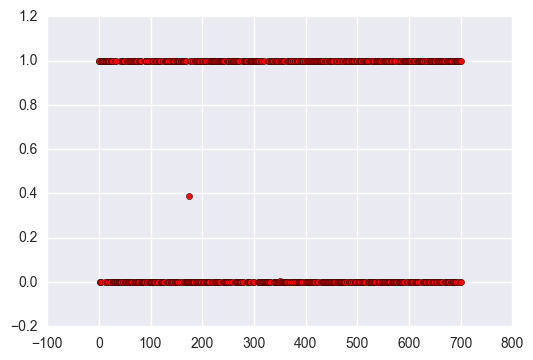

In [210]:
plt.figure()
plt.scatter(range(0,len(pred_prob)), pred_prob, c='r')
plt.show()

In [211]:
pred = xgbmodel.predict(X_test)
score = mean_squared_error(y_test, pred)

print("XGBoost Probablitiy Best RMSE: {}".format(np.sqrt(score).mean()))
print "Accuracy : %.4g" % metrics.accuracy_score(y_test.values, pred)

XGBoost Probablitiy Best RMSE: 0.0
Accuracy : 1


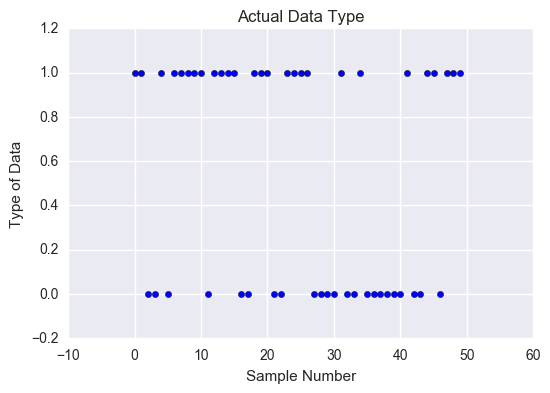

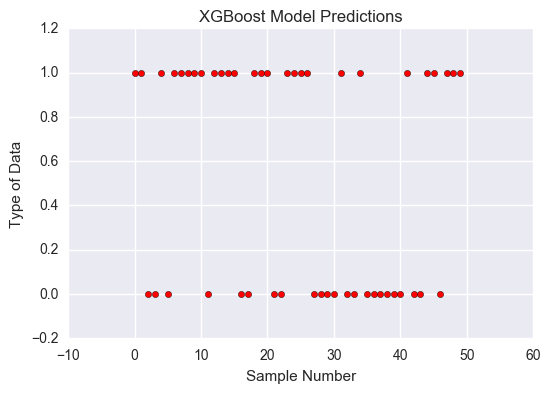

In [212]:
plt.figure()
plt.scatter(range(0,50), y_test[0:50])
plt.ylabel('Type of Data')
plt.xlabel('Sample Number')
plt.title('Actual Data Type')
plt.show()

plt.figure()
plt.scatter(range(0,50), pred[0:50], c='r')
plt.ylabel('Type of Data')
plt.xlabel('Sample Number')
plt.title('XGBoost Model Predictions')
plt.show()

## Predictions on normal data

In [190]:
bench_X_test = bench_data.ix[:,0:10]
bench_y_test = bench_data.ix[:,10]

bench_X_test = bench_X_test.astype(np.int64)

pred_bench = xgbmodel.predict(bench_X_test)
score = mean_squared_error(bench_y_test, pred_bench)

print("XGBoost Probablitiy Best RMSE: {}".format(np.sqrt(score).mean()))
print "Accuracy : %.4g" % metrics.accuracy_score(bench_y_test, pred_bench)

XGBoost Probablitiy Best RMSE: 0.0
Accuracy : 1


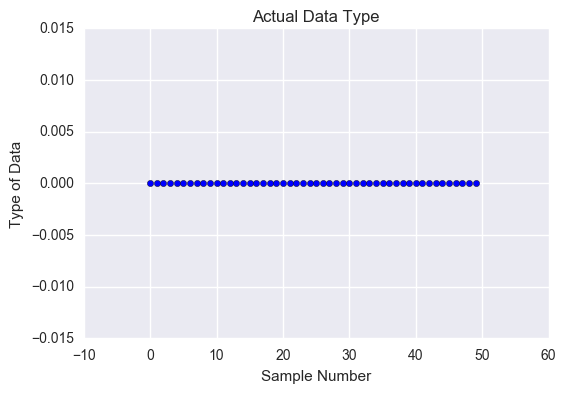

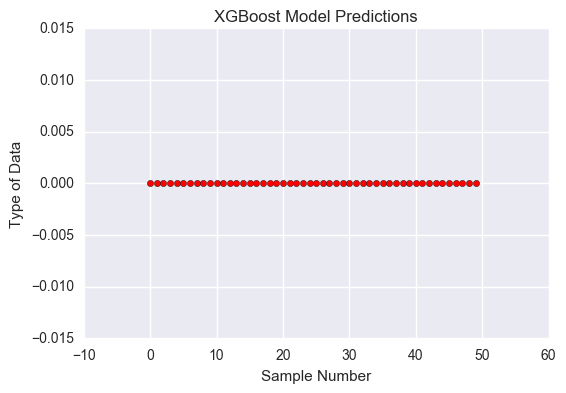

In [191]:
plt.figure()
plt.scatter(range(0,50), bench_y_test[0:50])
plt.ylabel('Type of Data')
plt.xlabel('Sample Number')
plt.title('Actual Data Type')
plt.show()

plt.figure()
plt.scatter(range(0,50), pred_bench[0:50], c='r')
plt.ylabel('Type of Data')
plt.xlabel('Sample Number')
plt.title('XGBoost Model Predictions')
plt.show()

## Predictions on attacked data

In [192]:
attack_X_test = attack_data.ix[:,0:10]
attack_y_test = attack_data.ix[:,10]

attack_X_test = attack_X_test.astype(np.int64)

pred_attack = xgbmodel.predict(attack_X_test)
score = mean_squared_error(attack_y_test, pred_attack)

print("XGBoost Probablitiy Best RMSE: {}".format(np.sqrt(score).mean()))
print "Accuracy : %.4g" % metrics.accuracy_score(attack_y_test, pred_attack)

XGBoost Probablitiy Best RMSE: 0.0
Accuracy : 1


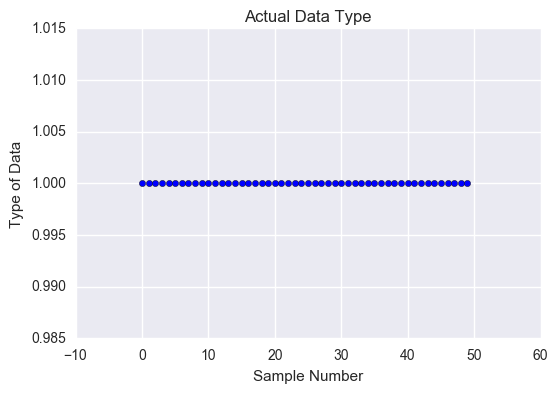

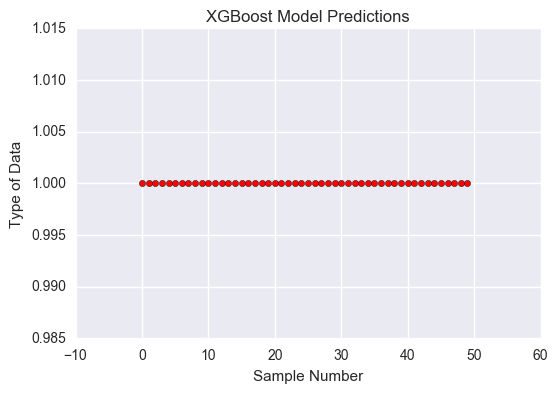

In [193]:
plt.figure()
plt.scatter(range(0,50), attack_y_test[0:50])
plt.ylabel('Type of Data')
plt.xlabel('Sample Number')
plt.title('Actual Data Type')
plt.show()

plt.figure()
plt.scatter(range(0,50), pred_attack[0:50], c='r')
plt.ylabel('Type of Data')
plt.xlabel('Sample Number')
plt.title('XGBoost Model Predictions')
plt.show()

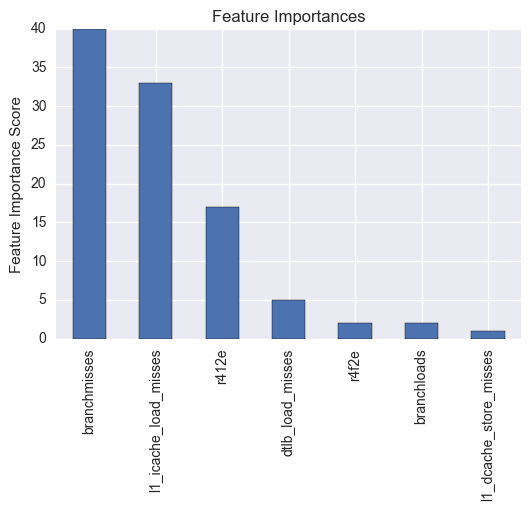

In [194]:
feat_imp = pd.Series(xgbmodel.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

## Running model on newly collected data (HMMER)

In [195]:
data1 = pd.read_csv('Data/Benchmark/hmmer_1.txt', delim_whitespace=True)
data1 = data1.drop(data1.columns[3], axis=1)
data1 = data1.drop(data1.columns[3], axis=1)
data1 = data1.drop(data1.columns[3], axis=1)
data1 = data1.drop(data1.columns[3], axis=1)
data1 = data1.drop(data1.columns[3], axis=1)
data1.columns = ['Time', 'Value', 'Type']

data2 = pd.read_csv('Data/Benchmark/hmmer_2.txt', delim_whitespace=True)
data2 = data2.drop(data2.columns[3], axis=1)
data2 = data2.drop(data2.columns[3], axis=1)
data2 = data2.drop(data2.columns[3], axis=1)
data2 = data2.drop(data2.columns[3], axis=1)
data2 = data2.drop(data2.columns[3], axis=1)
data2.columns = ['Time', 'Value', 'Type']

data3 = pd.read_csv('Data/Benchmark/hmmer_3.txt', delim_whitespace=True)
data3 = data3.drop(data3.columns[3], axis=1)
data3 = data3.drop(data3.columns[3], axis=1)
data3 = data3.drop(data3.columns[3], axis=1)
data3 = data3.drop(data3.columns[3], axis=1)
data3 = data3.drop(data3.columns[3], axis=1)
data3.columns = ['Time', 'Value', 'Type']

data3.head()

,Time,Value,Type
0,0.502321,4013262,L1-dcache-load-misses
1,0.502321,65298,dTLB-store-misses
2,0.502321,70282,dTLB-load-misses
3,1.005052,4317505,L1-dcache-load-misses
4,1.005052,61282,dTLB-store-misses


In [196]:
total = np.vstack([data1, data2, data3])

r412e = data1[data1.Type.isin(['r412e'])].reset_index(drop=True)
r4f2e = data1[data1.Type.isin(['r4f2e'])].reset_index(drop=True)
branchloads = data1[data1.Type.isin(['branch-loads'])].reset_index(drop=True)
branchmisses = data1[data1.Type.isin(['branch-load-misses'])].reset_index(drop=True)
faults = data1[data1.Type.isin(['faults'])].reset_index(drop=True)
dtlbload = data3[data3.Type.isin(['dTLB-load-misses'])].reset_index(drop=True)
dtlbstore = data3[data3.Type.isin(['dTLB-store-misses'])].reset_index(drop=True)
l1load = data3[data3.Type.isin(['L1-dcache-load-misses'])].reset_index(drop=True)
l1store = data2[data2.Type.isin(['L1-dcache-store-misses'])].reset_index(drop=True)
l1prefetch = data2[data2.Type.isin(['L1-dcache-prefetch-misses'])].reset_index(drop=True)
l1icacheload = data2[data2.Type.isin(['L1-icache-load-misses'])].reset_index(drop=True)

r412e = r412e.ix[range(0, 274),:]
r4f2e = r4f2e.ix[range(0, 274),:]
branchloads = branchloads.ix[range(0, 274),:]
branchmisses = branchmisses.ix[range(0, 274),:]
faults = faults.ix[range(0, 274),:]
dtlbload = dtlbload.ix[range(0, 274),:]
dtlbstore = dtlbstore.ix[range(0, 274),:]
l1load = l1load.ix[range(0, 274),:]
l1store = l1store.ix[range(0, 274),:]
l1prefetch = l1prefetch.ix[range(0, 274),:]
l1icacheload = l1icacheload.ix[range(0, 274),:]

print r412e.shape
print r4f2e.shape
print branchloads.shape
print branchmisses.shape
print faults.shape
print dtlbload.shape
print dtlbstore.shape
print l1load.shape
print l1store.shape
print l1prefetch.shape
print l1icacheload.shape

(274, 3)
(274, 3)
(274, 3)
(274, 3)
(274, 3)
(274, 3)
(274, 3)
(274, 3)
(274, 3)
(274, 3)
(274, 3)


In [197]:
r412e.index = range(len(r412e))
r4f2e.index = range(len(r4f2e))
branchloads.index = range(len(branchloads))
branchmisses.index = range(len(branchmisses))
faults.index = range(len(faults))
dtlbload.index = range(len(dtlbload))
dtlbstore.index = range(len(dtlbstore))
l1load.index = range(len(l1load))
l1store.index = range(len(l1store))
l1prefetch.index = range(len(l1prefetch))
l1icacheload.index = range(len(l1icacheload))

zeros = pd.DataFrame(np.zeros(len(r412e)))

bench_data = pd.concat([r412e.Value, r4f2e.Value, branchloads.Value, branchmisses.Value, 
                        faults.Value, dtlbload.Value, dtlbstore.Value, l1load.Value, l1store.Value, l1prefetch.Value,
                        l1icacheload.Value, zeros], axis=1)
bench_data.columns = ['r412e', 'r4f2e', 'branchloads', 'branchmisses', 'faults', 'dtlb_load_misses', 
                      'dtlb_store_misses', 'l1_dcache_load_misses', 'l1_dcache_store_misses', 
                      'l1_dcache_prefetch_misses', 'l1_icache_load_misses', 'type']
bench_data = bench_data.drop('l1_dcache_prefetch_misses', axis=1)

In [199]:
X_test = bench_data.ix[:,0:10]
y_test = bench_data.ix[:,10]

X_test = X_test.astype(np.int64)

pred = xgbmodel.predict(X_test)
pred_prob = xgbmodel.predict_proba(X_test)
pred_prob = pred_prob[:,1]

score = mean_squared_error(y_test, pred)

print("XGBoost Probablitiy Best RMSE: {}".format(np.sqrt(score).mean()))
print "Accuracy : %.4g" % metrics.accuracy_score(y_test, pred)

XGBoost Probablitiy Best RMSE: 0.0854357657717
Accuracy : 0.9927


In [200]:
print("Our Model's Types of samples: ")
pred = pd.DataFrame(pred)
pred.columns = ['Type']
print pred.Type.value_counts()[:10]

print("")

print("True Types of samples: ")
y_test = pd.DataFrame(y_test)
y_test.columns = ['Type']
print y_test.Type.value_counts()[:10]

Our Model's Types of samples: 
0.0    272
1.0      2
Name: Type, dtype: int64

True Types of samples: 
0.0    274
Name: Type, dtype: int64


# Pre-process Data

In [142]:
adata1 = pd.read_csv('Data/Attacked/flush_reload_1_out.txt', delim_whitespace=True)
adata1 = adata1.drop(adata1.columns[3], axis=1)
adata1 = adata1.drop(adata1.columns[3], axis=1)
adata1 = adata1.drop(adata1.columns[3], axis=1)
adata1 = adata1.drop(adata1.columns[3], axis=1)
adata1 = adata1.drop(adata1.columns[3], axis=1)
adata1.columns = ['Time', 'Value', 'Type']

adata2 = pd.read_csv('Data/Attacked/flush_reload_2_out.txt', delim_whitespace=True)
adata2 = adata2.drop(adata2.columns[3], axis=1)
adata2 = adata2.drop(adata2.columns[3], axis=1)
adata2 = adata2.drop(adata2.columns[3], axis=1)
adata2 = adata2.drop(adata2.columns[3], axis=1)
adata2 = adata2.drop(adata2.columns[3], axis=1)
adata2.columns = ['Time', 'Value', 'Type']

adata3 = pd.read_csv('Data/Attacked/flush_reload_3_out.txt', delim_whitespace=True)
adata3 = adata3.drop(adata3.columns[3], axis=1)
adata3 = adata3.drop(adata3.columns[3], axis=1)
adata3 = adata3.drop(adata3.columns[3], axis=1)
adata3 = adata3.drop(adata3.columns[3], axis=1)
adata3 = adata3.drop(adata3.columns[3], axis=1)
adata3.columns = ['Time', 'Value', 'Type']

adata3.head()

,Time,Value,Type
0,0.500938,3150986,L1-dcache-store-misses
1,0.500938,0,L1-dcache-prefetch-misses
2,0.500938,3121441,L1-icache-load-misses
3,1.001436,802859,L1-dcache-store-misses
4,1.001436,0,L1-dcache-prefetch-misses


In [143]:
atotal = np.vstack([adata1, adata2, adata3])

ar412e = adata1[adata1.Type.isin(['r412e'])].reset_index(drop=True)
ar4f2e = adata1[adata1.Type.isin(['r4f2e'])].reset_index(drop=True)
abranchloads = adata1[adata1.Type.isin(['branch-loads'])].reset_index(drop=True)
abranchmisses = adata1[adata1.Type.isin(['branch-load-misses'])].reset_index(drop=True)
afaults = adata1[adata1.Type.isin(['faults'])].reset_index(drop=True)
adtlbload = adata2[adata2.Type.isin(['dTLB-load-misses'])].reset_index(drop=True)
adtlbstore = adata2[adata2.Type.isin(['dTLB-store-misses'])].reset_index(drop=True)
al1load = adata2[adata2.Type.isin(['L1-dcache-load-misses'])].reset_index(drop=True)
al1store = adata3[adata3.Type.isin(['L1-dcache-store-misses'])].reset_index(drop=True)
al1prefetch = adata3[adata3.Type.isin(['L1-dcache-prefetch-misses'])].reset_index(drop=True)
al1icacheload = adata3[adata3.Type.isin(['L1-icache-load-misses'])].reset_index(drop=True)

In [144]:
data1 = pd.read_csv('Data/Benchmark/gobmk_1.txt', delim_whitespace=True)
data1 = data1.drop(data1.columns[3], axis=1)
data1 = data1.drop(data1.columns[3], axis=1)
data1 = data1.drop(data1.columns[3], axis=1)
data1 = data1.drop(data1.columns[3], axis=1)
data1 = data1.drop(data1.columns[3], axis=1)
data1.columns = ['Time', 'Value', 'Type']

data2 = pd.read_csv('Data/Benchmark/gobmk_2.txt', delim_whitespace=True)
data2 = data2.drop(data2.columns[3], axis=1)
data2 = data2.drop(data2.columns[3], axis=1)
data2 = data2.drop(data2.columns[3], axis=1)
data2 = data2.drop(data2.columns[3], axis=1)
data2 = data2.drop(data2.columns[3], axis=1)
data2.columns = ['Time', 'Value', 'Type']

data3 = pd.read_csv('Data/Benchmark/gobmk_3.txt', delim_whitespace=True)
data3 = data3.drop(data3.columns[3], axis=1)
data3 = data3.drop(data3.columns[3], axis=1)
data3 = data3.drop(data3.columns[3], axis=1)
data3 = data3.drop(data3.columns[3], axis=1)
data3 = data3.drop(data3.columns[3], axis=1)
data3.columns = ['Time', 'Value', 'Type']

data4 = data1
data5 = data2
data6 = data3

In [145]:
data1 = pd.read_csv('Data/Benchmark/zeusmp_1.txt', delim_whitespace=True)
data1 = data1.drop(data1.columns[3], axis=1)
data1 = data1.drop(data1.columns[3], axis=1)
data1 = data1.drop(data1.columns[3], axis=1)
data1 = data1.drop(data1.columns[3], axis=1)
data1 = data1.drop(data1.columns[3], axis=1)
data1.columns = ['Time', 'Value', 'Type']

data2 = pd.read_csv('Data/Benchmark/zeusmp_2.txt', delim_whitespace=True)
data2 = data2.drop(data2.columns[3], axis=1)
data2 = data2.drop(data2.columns[3], axis=1)
data2 = data2.drop(data2.columns[3], axis=1)
data2 = data2.drop(data2.columns[3], axis=1)
data2 = data2.drop(data2.columns[3], axis=1)
data2.columns = ['Time', 'Value', 'Type']

data3 = pd.read_csv('Data/Benchmark/zeusmp_3.txt', delim_whitespace=True)
data3 = data3.drop(data3.columns[3], axis=1)
data3 = data3.drop(data3.columns[3], axis=1)
data3 = data3.drop(data3.columns[3], axis=1)
data3 = data3.drop(data3.columns[3], axis=1)
data3 = data3.drop(data3.columns[3], axis=1)
data3.columns = ['Time', 'Value', 'Type']

data3.head()

,Time,Value,Type
0,0.500609489,13937419,L1-dcache-load-misses
1,0.500609489,540308,dTLB-store-misses
2,0.500609489,445148,dTLB-load-misses
3,1.000978352,17659473,L1-dcache-load-misses
4,1.000978352,357116,dTLB-store-misses


In [146]:
total = np.vstack([data1, data2, data3, data4, data5, data6])
total = pd.DataFrame(total)
total.columns = ['Time', 'Value', 'Type']

r412e = total[total.Type.isin(['r412e'])].reset_index(drop=True)
r4f2e = total[total.Type.isin(['r4f2e'])].reset_index(drop=True)
branchloads = total[total.Type.isin(['branch-loads'])].reset_index(drop=True)
branchmisses = total[total.Type.isin(['branch-load-misses'])].reset_index(drop=True)
faults = total[total.Type.isin(['faults'])].reset_index(drop=True)
dtlbload = total[total.Type.isin(['dTLB-load-misses'])].reset_index(drop=True)
dtlbstore = total[total.Type.isin(['dTLB-store-misses'])].reset_index(drop=True)
l1load = total[total.Type.isin(['L1-dcache-load-misses'])].reset_index(drop=True)
l1store = total[total.Type.isin(['L1-dcache-store-misses'])].reset_index(drop=True)
l1prefetch = total[total.Type.isin(['L1-dcache-prefetch-misses'])].reset_index(drop=True)
l1icacheload = total[total.Type.isin(['L1-icache-load-misses'])].reset_index(drop=True)

r412e = r412e.ix[range(0, 3495),:]
r4f2e = r4f2e.ix[range(0, 3495),:]
branchloads = branchloads.ix[range(0, 3495),:]
branchmisses = branchmisses.ix[range(0, 3495),:]
faults = faults.ix[range(0, 3495),:]
dtlbload = dtlbload.ix[range(0, 3495),:]
dtlbstore = dtlbstore.ix[range(0, 3495),:]
l1load = l1load.ix[range(0, 3495),:]
l1store = l1store.ix[range(0, 3495),:]
l1prefetch = l1prefetch.ix[range(0, 3495),:]
l1icacheload = l1icacheload.ix[range(0, 3495),:]

print r412e.shape
print r4f2e.shape
print branchloads.shape
print branchmisses.shape
print faults.shape
print dtlbload.shape
print dtlbstore.shape
print l1load.shape
print l1store.shape
print l1prefetch.shape
print l1icacheload.shape

(3495, 3)
(3495, 3)
(3495, 3)
(3495, 3)
(3495, 3)
(3495, 3)
(3495, 3)
(3495, 3)
(3495, 3)
(3495, 3)
(3495, 3)


In [147]:
r412e = pd.DataFrame(r412e)
r4f2e = pd.DataFrame(r4f2e)
branchloads = pd.DataFrame(branchloads)
branchmisses = pd.DataFrame(branchmisses)
faults = pd.DataFrame(faults)
dtlbload = pd.DataFrame(dtlbload)
dtlbstore = pd.DataFrame(dtlbstore)
l1load = pd.DataFrame(l1load)
l1store = pd.DataFrame(l1store)
l1prefetch = pd.DataFrame(l1prefetch)
l1icacheload = pd.DataFrame(l1icacheload)

r412e.columns = ['Time', 'Value', 'Type']
r4f2e.columns = ['Time', 'Value', 'Type']
branchloads.columns = ['Time', 'Value', 'Type']
branchmisses.columns = ['Time', 'Value', 'Type']
faults.columns = ['Time', 'Value', 'Type']
dtlbload.columns = ['Time', 'Value', 'Type']
dtlbstore.columns = ['Time', 'Value', 'Type']
l1load.columns = ['Time', 'Value', 'Type']
l1store.columns = ['Time', 'Value', 'Type']
l1prefetch.columns = ['Time', 'Value', 'Type']
l1icacheload.columns = ['Time', 'Value', 'Type']

r412e.index = range(len(r412e))
r4f2e.index = range(len(r4f2e))
branchloads.index = range(len(branchloads))
branchmisses.index = range(len(branchmisses))
faults.index = range(len(faults))
dtlbload.index = range(len(dtlbload))
dtlbstore.index = range(len(dtlbstore))
l1load.index = range(len(l1load))
l1store.index = range(len(l1store))
l1prefetch.index = range(len(l1prefetch))
l1icacheload.index = range(len(l1icacheload))

ones = pd.DataFrame(np.ones(len(ar412e)))
zeros = pd.DataFrame(np.zeros(len(r412e)))

bench_data = pd.concat([r412e.Value, r4f2e.Value, branchloads.Value, branchmisses.Value, 
                        faults.Value, dtlbload.Value, dtlbstore.Value, l1load.Value, l1store.Value, l1prefetch.Value,
                        l1icacheload.Value, zeros], axis=1)
bench_data.columns = ['r412e', 'r4f2e', 'branchloads', 'branchmisses', 'faults', 'dtlb_load_misses', 
                      'dtlb_store_misses', 'l1_dcache_load_misses', 'l1_dcache_store_misses', 
                      'l1_dcache_prefetch_misses', 'l1_icache_load_misses', 'type']
bench_data = bench_data.drop('l1_dcache_prefetch_misses', axis=1)

attack_data = pd.concat([ar412e.Value, ar4f2e.Value, abranchloads.Value, abranchmisses.Value, 
                        afaults.Value, adtlbload.Value, adtlbstore.Value, al1load.Value, al1store.Value, 
                        al1prefetch.Value, al1icacheload.Value, ones], axis=1)
attack_data.columns = ['r412e', 'r4f2e', 'branchloads', 'branchmisses', 'faults', 'dtlb_load_misses', 
                      'dtlb_store_misses', 'l1_dcache_load_misses', 'l1_dcache_store_misses', 
                      'l1_dcache_prefetch_misses', 'l1_icache_load_misses', 'type']
attack_data = attack_data.drop('l1_dcache_prefetch_misses', axis=1)

total_data = pd.concat([attack_data, bench_data], axis=0)
total_data.columns = ['r412e', 'r4f2e', 'branchloads', 'branchmisses', 'faults', 'dtlb_load_misses', 
                      'dtlb_store_misses', 'l1_dcache_load_misses', 'l1_dcache_store_misses', 
                      'l1_icache_load_misses', 'type']

# First, we'll shuffle the rows
total_data = total_data.dropna()
total_data = total_data.sample(frac=1).reset_index(drop=True)

In [148]:
msk = np.random.rand(len(total_data)) < 0.8
train = total_data[msk].reset_index(drop=True)
test = total_data[~msk].reset_index(drop=True)

X_train = train.ix[:,0:10]
y_train = train.ix[:,10]

X_test = test.ix[:,0:10]
y_test = test.ix[:,10]

X_train = X_train.astype(np.int64)
X_test = X_test.astype(np.int64)
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

print type(X_train.ix[0,0])
print type(y_train.ix[0,0])

<type 'numpy.int64'>
<type 'numpy.int64'>


In [149]:
xgbmodel = xgb.XGBClassifier()
xgbmodel.fit(X_train,y_train)

pred_prob = xgbmodel.predict_proba(X_test)
pred_prob = pred_prob[:,1]

score = mean_squared_error(y_test, pred_prob)
print("XGBoost Probablitiy Best RMSE: {}".format(np.sqrt(score).mean()))

XGBoost Probablitiy Best RMSE: 0.0395370717628


In [150]:
X_test = bench_data.ix[:,0:10]
y_test = bench_data.ix[:,10]

X_test = X_test.astype(np.int64)

pred = xgbmodel.predict(X_test)


score = mean_squared_error(y_test, pred)

print("XGBoost Probablitiy Best RMSE: {}".format(np.sqrt(score).mean()))
print "Accuracy : %.4g" % metrics.accuracy_score(y_test, pred)

XGBoost Probablitiy Best RMSE: 0.0239216651972
Accuracy : 0.9994


In [151]:
print("Our Model's Types of samples: ")
pred = pd.DataFrame(pred)
pred.columns = ['Type']
print pred.Type.value_counts()[:10]

print("")

print("True Types of samples: ")
y_test = pd.DataFrame(y_test)
y_test.columns = ['Type']
print y_test.Type.value_counts()[:10]

Our Model's Types of samples: 
0    3493
1       2
Name: Type, dtype: int64

True Types of samples: 
0.0    3495
Name: Type, dtype: int64


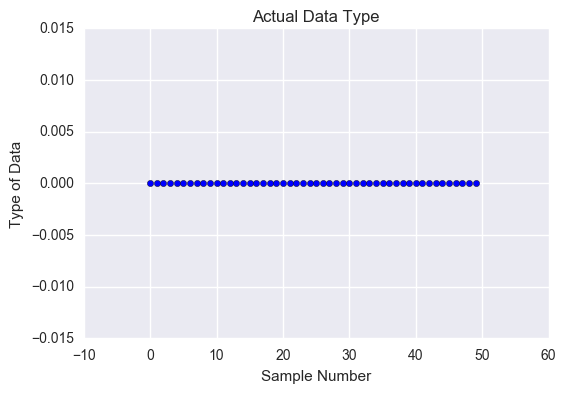

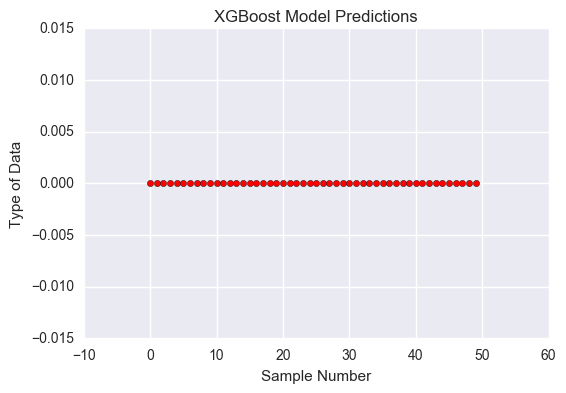

In [152]:
plt.figure()
plt.scatter(range(0,50), y_test[0:50])
plt.ylabel('Type of Data')
plt.xlabel('Sample Number')
plt.title('Actual Data Type')
plt.show()

plt.figure()
plt.scatter(range(0,50), pred[0:50], c='r')
plt.ylabel('Type of Data')
plt.xlabel('Sample Number')
plt.title('XGBoost Model Predictions')
plt.show()

## Predictions on ZeusMP

In [153]:
data1 = pd.read_csv('Data/Benchmark/zeusmp_1.txt', delim_whitespace=True)
data1 = data1.drop(data1.columns[3], axis=1)
data1 = data1.drop(data1.columns[3], axis=1)
data1 = data1.drop(data1.columns[3], axis=1)
data1 = data1.drop(data1.columns[3], axis=1)
data1 = data1.drop(data1.columns[3], axis=1)
data1.columns = ['Time', 'Value', 'Type']

data2 = pd.read_csv('Data/Benchmark/zeusmp_2.txt', delim_whitespace=True)
data2 = data2.drop(data2.columns[3], axis=1)
data2 = data2.drop(data2.columns[3], axis=1)
data2 = data2.drop(data2.columns[3], axis=1)
data2 = data2.drop(data2.columns[3], axis=1)
data2 = data2.drop(data2.columns[3], axis=1)
data2.columns = ['Time', 'Value', 'Type']

data3 = pd.read_csv('Data/Benchmark/zeusmp_3.txt', delim_whitespace=True)
data3 = data3.drop(data3.columns[3], axis=1)
data3 = data3.drop(data3.columns[3], axis=1)
data3 = data3.drop(data3.columns[3], axis=1)
data3 = data3.drop(data3.columns[3], axis=1)
data3 = data3.drop(data3.columns[3], axis=1)
data3.columns = ['Time', 'Value', 'Type']

data3.head()

,Time,Value,Type
0,0.500609489,13937419,L1-dcache-load-misses
1,0.500609489,540308,dTLB-store-misses
2,0.500609489,445148,dTLB-load-misses
3,1.000978352,17659473,L1-dcache-load-misses
4,1.000978352,357116,dTLB-store-misses


In [154]:
total = np.vstack([data1, data2, data3])

r412e = data1[data1.Type.isin(['r412e'])].reset_index(drop=True)
r4f2e = data1[data1.Type.isin(['r4f2e'])].reset_index(drop=True)
branchloads = data1[data1.Type.isin(['branch-loads'])].reset_index(drop=True)
branchmisses = data1[data1.Type.isin(['branch-load-misses'])].reset_index(drop=True)
faults = data1[data1.Type.isin(['faults'])].reset_index(drop=True)
dtlbload = data3[data3.Type.isin(['dTLB-load-misses'])].reset_index(drop=True)
dtlbstore = data3[data3.Type.isin(['dTLB-store-misses'])].reset_index(drop=True)
l1load = data3[data3.Type.isin(['L1-dcache-load-misses'])].reset_index(drop=True)
l1store = data2[data2.Type.isin(['L1-dcache-store-misses'])].reset_index(drop=True)
l1prefetch = data2[data2.Type.isin(['L1-dcache-prefetch-misses'])].reset_index(drop=True)
l1icacheload = data2[data2.Type.isin(['L1-icache-load-misses'])].reset_index(drop=True)

r412e = r412e.ix[range(0, 1726),:]
r4f2e = r4f2e.ix[range(0, 1726),:]
branchloads = branchloads.ix[range(0, 1726),:]
branchmisses = branchmisses.ix[range(0, 1726),:]
faults = faults.ix[range(0, 1726),:]
dtlbload = dtlbload.ix[range(0, 1726),:]
dtlbstore = dtlbstore.ix[range(0, 1726),:]
l1load = l1load.ix[range(0, 1726),:]
l1store = l1store.ix[range(0, 1726),:]
l1prefetch = l1prefetch.ix[range(0, 1726),:]
l1icacheload = l1icacheload.ix[range(0, 1726),:]

print r412e.shape
print r4f2e.shape
print branchloads.shape
print branchmisses.shape
print faults.shape
print dtlbload.shape
print dtlbstore.shape
print l1load.shape
print l1store.shape
print l1prefetch.shape
print l1icacheload.shape

(1726, 3)
(1726, 3)
(1726, 3)
(1726, 3)
(1726, 3)
(1726, 3)
(1726, 3)
(1726, 3)
(1726, 3)
(1726, 3)
(1726, 3)


In [155]:
r412e.index = range(len(r412e))
r4f2e.index = range(len(r4f2e))
branchloads.index = range(len(branchloads))
branchmisses.index = range(len(branchmisses))
faults.index = range(len(faults))
dtlbload.index = range(len(dtlbload))
dtlbstore.index = range(len(dtlbstore))
l1load.index = range(len(l1load))
l1store.index = range(len(l1store))
l1prefetch.index = range(len(l1prefetch))
l1icacheload.index = range(len(l1icacheload))

zeros = pd.DataFrame(np.zeros(len(r412e)))

bench_data = pd.concat([r412e.Value, r4f2e.Value, branchloads.Value, branchmisses.Value, 
                        faults.Value, dtlbload.Value, dtlbstore.Value, l1load.Value, l1store.Value, l1prefetch.Value,
                        l1icacheload.Value, zeros], axis=1)
bench_data.columns = ['r412e', 'r4f2e', 'branchloads', 'branchmisses', 'faults', 'dtlb_load_misses', 
                      'dtlb_store_misses', 'l1_dcache_load_misses', 'l1_dcache_store_misses', 
                      'l1_dcache_prefetch_misses', 'l1_icache_load_misses', 'type']
bench_data = bench_data.drop('l1_dcache_prefetch_misses', axis=1)

In [156]:
X_test = bench_data.ix[:,0:10]
y_test = bench_data.ix[:,10]

X_test = X_test.astype(np.int64)

pred = xgbmodel.predict(X_test)
pred_prob = xgbmodel.predict_proba(X_test)
pred_prob = pred_prob[:,1]

score = mean_squared_error(y_test, pred)

print("XGBoost Probablitiy Best RMSE: {}".format(np.sqrt(score).mean()))
print "Accuracy : %.4g" % metrics.accuracy_score(y_test, pred)
print "Model's Final Determination : %.4g" % pred.mean()

XGBoost Probablitiy Best RMSE: 0.0340403958785
Accuracy : 0.9988
Model's Final Determination : 0.001159


In [157]:
print("Our Model's Types of samples: ")
pred = pd.DataFrame(pred)
pred.columns = ['Type']
print pred.Type.value_counts()[:10]

print("")

print("True Types of samples: ")
y_test = pd.DataFrame(y_test)
y_test.columns = ['Type']
print y_test.Type.value_counts()[:10]

Our Model's Types of samples: 
0    1724
1       2
Name: Type, dtype: int64

True Types of samples: 
0.0    1726
Name: Type, dtype: int64


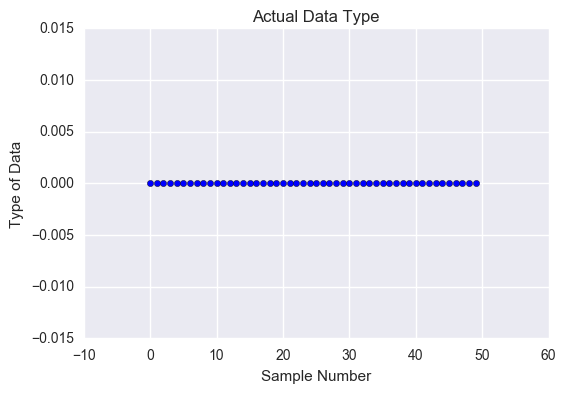

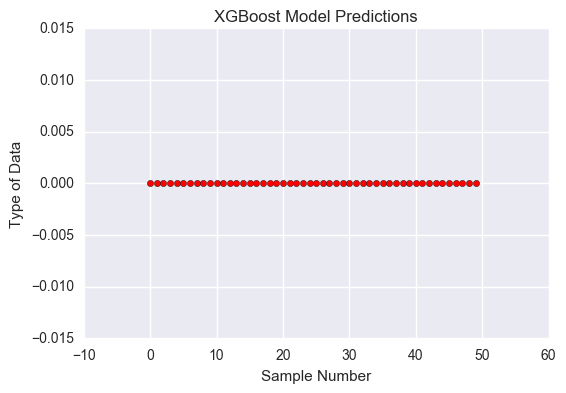

In [158]:
plt.figure()
plt.scatter(range(0,50), y_test[0:50])
plt.ylabel('Type of Data')
plt.xlabel('Sample Number')
plt.title('Actual Data Type')
plt.show()

plt.figure()
plt.scatter(range(0,50), pred[0:50], c='r')
plt.ylabel('Type of Data')
plt.xlabel('Sample Number')
plt.title('XGBoost Model Predictions')
plt.show()

In [159]:
xgbmodel

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)